In [1]:
import numpy as np

from nn.module import Linear,TanH,Sigmoide,Softmax
from nn.loss import CElogSoftMax,MSELoss,CELoss, BCELoss
from tools.nntools import Sequentiel, Optim
from tools.basic import load_usps, show_image,draw_pred,draw_construction, draw_noise,add_noise
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn import metrics
from keras.datasets import mnist

In [2]:
def onehot(x): # single digit
    out = [0] * 10
    out[x] = 1
    return out


In [3]:
def draw_TSNE(data,labels): # inspired by sklearn demo.
    
    reduced_data = TSNE().fit_transform(data).astype('double')
    kmeans = KMeans(init="k-means++", n_clusters=10, n_init=4)
    kmeans.fit(reduced_data)
    
    h = .02

    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure()
    plt.clf()
    plt.imshow(Z, interpolation="nearest",
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap='cool', aspect="auto", origin="lower")

    plt.scatter(reduced_data[:, 0], reduced_data[:, 1],s=10, c=labels)
    plt.title("TSNE representation 10 clusters")
    plt.show()

In [4]:
def clustering(data, labels):

    kmeans = KMeans(init="k-means++", n_clusters=10, n_init=4,random_state=0)
    pred = kmeans.fit_predict(data)
    
    clustering_metrics = [\
        metrics.homogeneity_score,\
        metrics.completeness_score,\
        metrics.v_measure_score,\
        metrics.adjusted_rand_score,\
        metrics.adjusted_mutual_info_score,
    ]

    scores = [m(labels,pred) for m in clustering_metrics]
    
    print("homogeneity_score :", scores[0])
    print("completeness_score :", scores[1])
    print("v_measure_score :", scores[2])
    print("adjusted_rand_score :", scores[3])
    print("adjusted_mutual_info_score :", scores[4])
    
    return scores

In [5]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# building the input vector from the 28x28 pixels
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalizing the data to help with the training
X_train /= 255
X_test /= 255


X_train = X_train[:5000]
y_train = y_train[:5000]
X_test = X_train[:1000]
y_test = y_train[:1000]


p = 0.8
X_train_noise = add_noise(X_train,p=p)
X_test_noise = add_noise(X_test,p=p) 

type=2


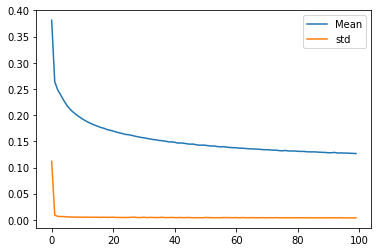

In [6]:
n = X_train.shape[1]
hidden = 100
d = 144


iteration = 100
gradient_step = 1e-4
batchsize = 100


lin_layer = Linear(n, hidden)
lin_layer2 = Linear(hidden, d)
lin_layer3 = Linear(d, hidden)
lin_layer3._params = lin_layer2._params.T
lin_layer4 = Linear(hidden, n)
lin_layer4._params = lin_layer._params.T

loss = BCELoss()

Encodeur = [lin_layer,TanH(),lin_layer2,TanH()]
Decodeur = [lin_layer3,TanH(),lin_layer4,Sigmoide()]

net = Sequentiel(Encodeur + Decodeur)

opt = Optim(net,loss,eps=gradient_step)
mean, std = opt.SGD(X_train,X_train,batchsize,iteration,earlystop=50)
plt.figure()
plt.plot(mean)
plt.plot(std)
plt.legend(('Mean', 'std'))
plt.show()


In [7]:
reconstructed = opt._net.predict(X_test_noise)

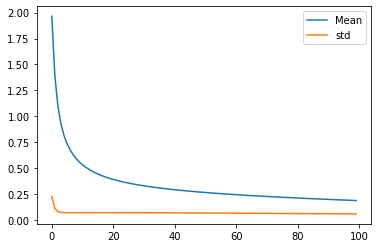

accuracy :  0.828


In [8]:
y_train = np.asarray([onehot(x) for x in y_train])

type=2

n = X_train.shape[1]
hidden1 = 128
hidden2 = 64
d = 10


iteration = 100
gradient_step = 1e-4
batchsize = 100

def label_func(x):
    return np.argmax(x,axis=1)

lin_layer = Linear(n, hidden1,type=type)
lin_layer2 = Linear(hidden1, hidden2,type=type)
lin_layer3 = Linear(hidden2, d,type=type)
act_softmax = Softmax()
act_tan = TanH()
act_tan2 = TanH()
loss = CElogSoftMax()



net = Sequentiel([lin_layer,act_tan,lin_layer2,act_tan,lin_layer3],labels=label_func)

opt = Optim(net,loss,eps=gradient_step)
mean, std = opt.SGD(X_train,y_train,batchsize,iteration,earlystop=50)
plt.figure()
plt.plot(mean)
plt.plot(std)
plt.legend(('Mean', 'std'))
plt.show()


print("accuracy : ",opt.score(reconstructed,y_test))